<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_______________________________________

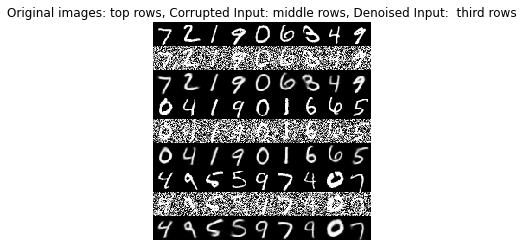

In [1]:
'''Trains a denoising autoencoder on MNIST dataset.
Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.
Noise + Data ---> Denoising Autoencoder ---> Data
Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.
This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''
# __future__는 파이썬 버전 조정

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64) for 문을 사용해서 두 개의 Layer를 만듬
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,   
               activation='relu',
               padding='same')(x)

# strides를 2로 설정하였기 때문에 출력배열의 크기가 반으로 줄어든다.
#  결국 32, 64 두번 합성곱층을 지나가게 되므로 입력배열의 크기는 1/4로 줄어든다. 
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model 인코더단계에서 산출되는 행렬은 16개이다. 결국 28*28*1의 정보는 16개 배열로 압축된 것으로 생각할 수 있다.
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved, 디코드에서는 출력행렬의 크기를 다시 증가시킨다.
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)

# Conv2DTranspose는 전치합성곱이다. strides 크기만큼  배열의 크기가 증가된다.
for filters in layer_filters[::-1]:  # -1을 사용하면 순서가 뒤집어 진다. [32,64] --> [64,32]
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input 필터개수를 1개로 축소해서 원래의 이미지 28*28*1로 전환시킨다. 
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
# 여기가 백미이네.... 오토인코더는 inputs이 들어가고 그 input이 인코더로 들어가고 다시 디코딩 된것이 outputs이다.
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

**정상데이터가 중심이된 오토인코도에 비정상 데이터를 넣으면 디코딩된 정보가 정상데이터와 다른 형태를 가지게 될 것이라는 것이 핵심**

먼저, Supervised Learning 방식은 주어진 학습 데이터 세트가 정상 및 비정상 데이터 모두 라벨(Label)이 존재한다. 이는 다른 방법 대비 정확도가 굉장히 높다는 특징을 가진다. 그래서 높은 정확도를 요구로 하는 경우에 주로 사용되며, 비정상 데이터들을 다양하게 보유할 수록 더 높은 정확도를 가질 수 있다. 그러나 실세계에서는 정상 데이터들보다 비정상 데이터들의 발생 빈도가 현저히 낮기 때문에 클래스 불균형(Class-Imbalance) 문제를 겪게 된다. 이러한 문제를 해결하기 위해 데이터 증강(Data Augmentation), 손실 함수(Loss Function) 재설계, 배치 샘플링(Batch Sampling) 등 다양한 연구가 수행되고 있다. 하지만 가장 큰 문제는 비정상 데이터들을 확보하는데 많은 시간과 비용이 소요된다는 것이다. 예를 들면 제조업에서 수백만장의 정상 데이터들이 취득되는 동안 단 1장 또는 2장의 비정상 데이터가 취득되기 때문에 현장에 적용하기에는 무리가 있다.

앞서 Supervised 및 Semi-supervised Learning 방법은 입력 데이터가 정상 데이터인지 알기 위해서는 모든 정상 데이터에 대한 라벨이 필요하다. 하지만 Unsupervised Learning 방법은 대부분의 모든 데이터가 정상 데이터라고 간주를 하고, 라벨 필요 없이 학습을 시키는 방식이다. 가장 단순하게 주성분 분석(PCA)을 이용하여 차원을 축소하고, 복원을 하는 과정을 통해 비정상 데이터들을 검출 할 수 있다. 또한 신경망 기반으로는 오토인코더(Autoencoder) 방법론이 주로 사용되고 있다고 한다. 오토인코더는 입력을 latent variable 로 압축하는 인코딩(Encoding) 과정과 이를 다시 원본과 가깝게 복원하는 디코딩(Decoding) 과정으로 진행되며, 이를 통해 데이터의 중요한 정보들만 압축적으로 학습할 수 있기 때문에 PCA와 유사하게 동작한다고 한다. 아래 그림과 같이 오토인코더는 입력을 그대로 출력(복원) 하도록 하는 목적 함수를 갖는다. 보통 MSE(Mean Squared Error, 평균 제곱 오차) 손실함수를 사용하며, 중간에 병목(bottle-neck)이 있어 고차원 공간 상의 입력 데이터를 저차원의 공간으로 매핑하여 latent variable 로 표현했다가, 다시 입력과 같은 고차원 공간으로 복원해야한다. 여기서 인코더와 디코더는 여러개의 비선형(Non-linear) 레이어(계층)를 가질 수 있으며, non-linear activation 함수를 없애서 선형적인 형태로 오토인코더를 구성할 경우 PCA 처럼 동작하게 된다. 

In [4]:
a =[32, 64]

In [5]:
a[::-1]

[64, 32]